# An Introduction to Algorithms in Qiskit

This is an introduction to algorithms in Qiskit and provides a high-level overview to help understand the various aspects of the functionality to get started. Other tutorials will provide more in-depth material, on given algorithms, and ways to use them etc.

## How is the algorithm library structured?

Qiskit provides a number of [Algorithms](https://qiskit.org/documentation/apidoc/qiskit.aqua.algorithms.html) and they are grouped by category according to the task they can perform. For instance `Minimum Eigensolvers` to find the smallest eigen value of an operator, for example ground state energy of a chemistry Hamiltonian or a solution to an optimization problem when expressed as an Ising Hamiltonian. There are `Classifiers` for machine learning  classification problems and `Amplitude Estimators` for value estimation that can be used say in financial applications. The full set of categories can be seen in the Algorithms documentation link above.

Algorithms are configurable and often part of the configuration will be in the form of smaller building blocks, of which different instances of the building block type can be given. For instance with `VQE`, the Variational Quantum Eigensolver, it takes a trial wavefunction, in the form of a `QuantumCircuit` and a classical optimizer among other things. Such building blocks can be found as [Components](https://qiskit.org/documentation/apidoc/qiskit.aqua.components.html) and as circuits from the [Circuit Library](https://qiskit.org/documentation/apidoc/circuit_library.html).

Let's take a look at an example to construct a VQE instance. Here `TwoLocal` is the variational form (trial wavefunction), a parameterized circuit which can be varied, and `SLSQP` a classical optimizer. These are created as separate instances and passed to VQE when it is constructed. Trying, for example, a different classical optimizer, or variational form is simply a case of creating an instance of the one you want and passing it into VQE.

In [1]:
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

num_qubits = 2
ansatz = TwoLocal(num_qubits, 'ry', 'cz')
opt = SLSQP(maxiter=1000)
vqe = VQE(var_form=ansatz, optimizer=opt)

Let's draw the ansatz so we can see it's a QuantumCircuit where θ\[0\] through θ\[7\] will be the parameters that are varied as VQE optimizer finds the minimum eigenvalue. We'll come back to the parameters later in a working example below.

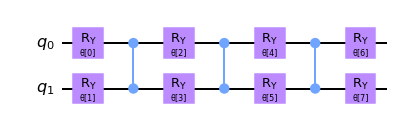

In [2]:
ansatz.draw()

But more is needed before we can run the algorithm so let's get to that next.

## How to run an algorithm?

In order to run an algorithm we need to have backend, a simulator or real device, on which the circuits that comprise the algorithm can be run. So for example we can use the `statevector_simulator` from the BasicAer provider.

In [3]:
from qiskit import BasicAer

backend = BasicAer.get_backend('statevector_simulator')

Now a backend on its own does not have information on how you might want to run the circuits etc. For example how many shots, do you want a noise model, even options around transpiling the circuits. For this Qiskit Aqua has a [QuantumInstance](https://qiskit.org/documentation/stubs/qiskit.aqua.QuantumInstance.html) which is provided both the backend as well as various settings around the circuit processing and execution so for instance:

In [4]:
from qiskit.aqua import QuantumInstance

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=800, seed_simulator=99) 

Note: if you provide the backend directly then internally a QuantumInstance will be created from it, with default settings, so at all times the algorithms are working through a QuantumInstance.

So now we would be able to call the [run()](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQE.html#qiskit.aqua.algorithms.VQE.run) method, which is common to all algorithms and returns a result specific for the algorithm. In this case since VQE is a MinimumEigensolver we could use the [compute_mininum_eigenvalue()](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQE.html#qiskit.aqua.algorithms.VQE.compute_minimum_eigenvalue) method. The latter is the interface of choice for the application modules, such as Chemistry and Optimization, in order that they can work interchangeably with any algorithm within the specific category.

## A complete working example

Let's put what we have learned from above together and create a complete working example. VQE will find the minimum eigenvalue, i.e. minimum energy value of a Hamiltonian operator and hence we need such an operator for VQE to work with. Such an operator is given below. This was originally created by the Chemistry application module as the Hamiltonian for an H2 molecule at 0.735A interatomic distance. It's a sum of Pauli terms as below, but for now I am not going to say anything further about it since the goal is to run the algorithm, but further information on operators can be found in other tutorials.

In [5]:
from qiskit.aqua.operators import X, Z, I

H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

So let's build a VQE instance passing the operator, and a backend using a QuantumInstance, to the constructor. Now VQE does have setters so the operator and backend can also be passed later. Setting them later can be useful when creating an algorithm without this problem specific information and then later using it, say with the chemistry application module, which would create the operator for the specific chemistry problem being solved.

Note: In order that you can run this notebook and see the exact same output the random number generator used throughout Aqua in aqua_globals, as well as the transpiler and simulator, via the QuantumInstance, are seeded. You do not have to do this but if want to be able to reproduce the exact same outcome each time then this is how it's done.

So let's run VQE and print the result object it returns.

In [6]:
from qiskit.aqua import aqua_globals
seed = 50
aqua_globals.random_seed = seed
qi = QuantumInstance(BasicAer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
slsqp = SLSQP(maxiter=1000)
vqe = VQE(operator=H2_op, var_form=ansatz, optimizer=slsqp, quantum_instance=qi)
result = vqe.run()

import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(result)

{   'cost_function_evals': 72,
    'eigenstate': array([-9.55448660e-05+2.12037105e-17j,  9.93766273e-01+2.25293943e-16j,
       -1.11483565e-01+1.52657541e-16j, -1.77521351e-05+3.71607315e-17j]),
    'eigenvalue': (-1.857275017559769+0j),
    'optimal_parameters': {   Parameter(θ[0]): 4.296520551468743,
                              Parameter(θ[1]): 4.426962086704216,
                              Parameter(θ[2]): 0.5470753710293924,
                              Parameter(θ[7]): 0.3602072316165878,
                              Parameter(θ[6]): -4.717618235040379,
                              Parameter(θ[5]): 1.5683261371389359,
                              Parameter(θ[3]): 6.09294789784282,
                              Parameter(θ[4]): -2.598325857134344},
    'optimal_point': array([ 4.29652055,  4.42696209,  0.54707537,  6.0929479 , -2.59832586,
        1.56832614, -4.71761824,  0.36020723]),
    'optimal_value': -1.857275017559769,
    'optimizer_evals': 72,
    'optimizer_tim

From the above result we can see it took the optimizer `72` evaluations of parameter values until it found the minimum eigenvalue of `-1.85727` which is the electronic ground state energy of the given H2 molecule. The optimal parameters of the ansatz can also be seen which are the values that were in the ansatz at the minimum value.

## Using VQE as a MinimumEigensolver

To close off let's use the MinimumEigensolver interface and also create a VQE instance without supplying either the operator or QuantumInstance. We later set the QuantumInstance and finally pass the operator on the `compute_minimum_eigenvalue` method (though we could have passed it in earlier via the setter instead, as long as by the time VQE runs it has an operator to work on).

In [7]:
aqua_globals.random_seed = seed
qi = QuantumInstance(BasicAer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
slsqp = SLSQP(maxiter=1000)
vqe = VQE(var_form=ansatz, optimizer=slsqp)

vqe.quantum_instance = qi
result = vqe.compute_minimum_eigenvalue(operator=H2_op)

pp.pprint(result)

{   'cost_function_evals': 72,
    'eigenstate': array([-9.55448660e-05+2.12037105e-17j,  9.93766273e-01+2.25293943e-16j,
       -1.11483565e-01+1.52657541e-16j, -1.77521351e-05+3.71607315e-17j]),
    'eigenvalue': (-1.857275017559769+0j),
    'optimal_parameters': {   Parameter(θ[4]): -2.598325857134344,
                              Parameter(θ[5]): 1.5683261371389359,
                              Parameter(θ[6]): -4.717618235040379,
                              Parameter(θ[7]): 0.3602072316165878,
                              Parameter(θ[1]): 4.426962086704216,
                              Parameter(θ[0]): 4.296520551468743,
                              Parameter(θ[2]): 0.5470753710293924,
                              Parameter(θ[3]): 6.09294789784282},
    'optimal_point': array([ 4.29652055,  4.42696209,  0.54707537,  6.0929479 , -2.59832586,
        1.56832614, -4.71761824,  0.36020723]),
    'optimal_value': -1.857275017559769,
    'optimizer_evals': 72,
    'optimizer_tim

As the identical seeding was used as the prior example the result can be seen to be the same.

This concludes this introduction to algorithms in Qiskit. Please check out the other algorithm tutorials in this series for both broader as well as more in depth coverage of the algorithms.

In [8]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright